In [55]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measure_table = Base.classes.measurement
station_table = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_dt = session.query(measure_table.date).order_by(measure_table.date.desc()).first()[0]
most_recent_dt



'2017-08-23'

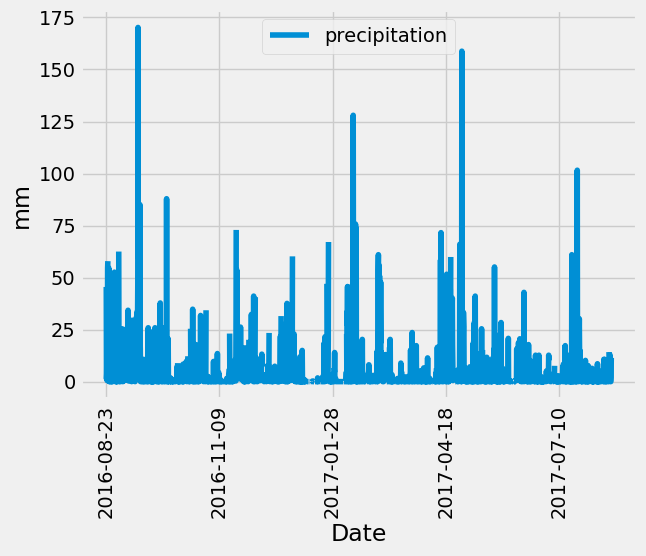

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent_dt, "%Y-%m-%d")
most_recent_date = most_recent_date.date()

year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(measure_table.date, measure_table.prcp).filter(measure_table.date >= year_ago).filter(measure_table.date <= most_recent_dt)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
year_prcp_df = pd.DataFrame(year_prcp, columns = ["Date", "precipitation"])
year_prcp_df.set_index("Date", inplace=True)

# Sort the dataframe by date
year_prcp_df = year_prcp_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
year_prcp_df.plot()
plt.tight_layout()
plt.xticks(rotation="vertical")
plt.xlabel("Date",size=17)
plt.ylabel("mm",size=17)
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
year_prcp_df.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
unique_stns_total = session.query(measure_table.station).distinct().count()
unique_stns_total

9

In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stns = session.query(measure_table.station, func.count(measure_table.station))\
    .group_by(measure_table.station).order_by(func.count(measure_table.station).desc()).all()

active_stns

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stn = session.query(measure_table.station, func.count(measure_table.station))\
    .group_by(measure_table.station).order_by(func.count(measure_table.station).desc()).first()

most_active_stn_id = most_active_stn[0]

#Lowest Temp
lowest_temp = session.query(func.min(measure_table.tobs)).\
    filter(measure_table.station == most_active_stn_id).all()[0]

#Highest Temp
highest_temp = session.query(func.max(measure_table.tobs)).\
    filter(measure_table.station == most_active_stn_id).all()[0]

#Average Temp
avg_temp = session.query(func.avg(measure_table.tobs)).\
    filter(measure_table.station == most_active_stn_id).all()[0]

#Printing Temp info
print(f"The lowest temperature at the most active station, {most_active_stn_id}, is {lowest_temp}")
print(f"The highest temperature at the same station is {highest_temp}")
print(f"The average temperature at the same station is {avg_temp}")


The lowest temperature at the most active station, USC00519281, is (12.2,)
The highest temperature at the same station is (29.4,)
The average temperature at the same station is (22.03582251082252,)


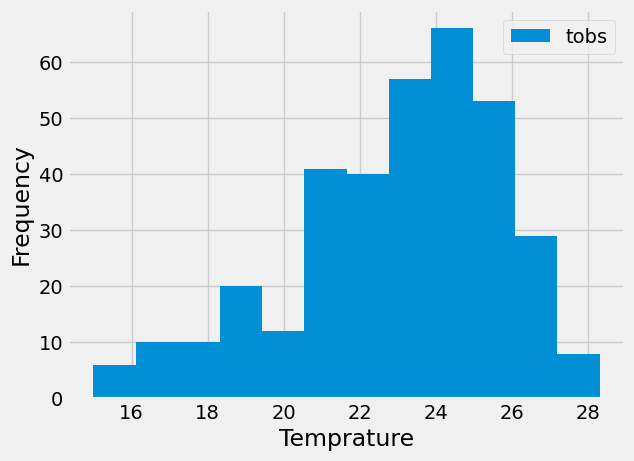

In [54]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_year_temp_obs = session.query(measure_table.tobs).\
    filter(measure_table.station == most_active_stn_id).\
    filter(measure_table.date >= year_ago)

# Casting observations into Pandas DataFrame
station_year_tobs_df = pd.DataFrame(station_year_temp_obs)

# Plotting Histogram of Dataframe with Matplotlib
station_year_tobs_df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temprature",size=17)
plt.ylabel("Frequency",size=17)
plt.show()


# Close Session

In [57]:
# Close Session
session.close()